In [1]:
%matplotlib inline
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=3

import os
import cv2
import numpy as np
import torch
from torch.autograd import Variable
import quat_math
import pickle
import glob

from PIL import Image
import scipy.io as scio
from functools import partial
from object_pose_utils.utils import to_np, to_var
from object_pose_utils.utils.display import *

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import warnings
warnings.filterwarnings('ignore')

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=3


## Dataset Information

In [2]:
from object_pose_utils.datasets.ycb_dataset import YcbDataset as YCBDataset
from object_pose_utils.datasets.pose_dataset import OutputTypes as otypes

dataset_root = '/ssd0/datasets/ycb/YCB_Video_Dataset'
object_list = list(range(1,22))
mode = "test"

output_format = [otypes.OBJECT_LABEL,
                 otypes.QUATERNION, 
                 otypes.TRANSLATION, 
                 otypes.TRANSFORM_MATRIX,
                ]

dataset = YCBDataset(dataset_root, mode=mode,
                     object_list = list(range(1,22)),
                     output_data = output_format,
                     resample_on_error = False,
                     add_syn_background = False,
                     add_syn_noise = False,
                     use_posecnn_data = True,
                     #preprocessors = [InplaneRotator()],
                     #postprocessors = [ImageNormalizer()],
                     image_size = [640, 480], num_points=1000)

feature_root = '/scratch/bokorn/results/dense_fusion_local_orig_feat/'
grid_vertices = torch.load(os.path.join(feature_root, 'grid',
    '{}_vertices.pt'.format(dataset.classes[1])))

In [3]:
from generic_pose.losses.bingham_loss import isoLikelihood, duelLikelihood

In [6]:
results_comp = 'ral_results/pcnn_single_img_hist_comp_fc6_results.npz'
data = np.load(results_comp, allow_pickle=True)
results = {k:v.item() for k,v in data.items()}

lik_distribution = results['lik_distribution']['hist_comp_fc6']

In [7]:
lik_distribution[13].keys()

dict_keys([9173, 9174, 9175, 9176, 9177, 9178, 9179, 9180, 9181, 9182, 9183, 9184, 9185, 9186, 9187, 9188, 9189, 9190, 9191, 9192, 9193, 9194, 9195, 9196, 9197, 9198, 9199, 9200, 9201, 9202, 9203, 9204, 9205, 9206, 9207, 9208, 9209, 9210, 9211, 9212, 9213, 9214, 9215, 9216, 9217, 9218, 9219, 9220, 9221, 9222, 9223, 9224, 9225, 9226, 9227, 9228, 9229, 9230, 9231, 9232, 9233, 9234, 9235, 9236, 9237, 9238, 9239, 9240, 9241, 9242, 9243, 9244, 9245, 9246, 9247, 9248, 9249, 9250, 9251, 9252, 9253, 9254, 9255, 9256, 9257, 9258, 9259, 9260, 9261, 9262, 9263, 9264, 9265, 9266, 9267, 9268, 9269, 9270, 9271, 9272, 9273, 9274, 9275, 9276, 9277, 9278, 9279, 9280, 9281, 9282, 9283, 9284, 9285, 9286, 9287, 9288, 9289, 9290, 9291, 9292, 9293, 9294, 9295, 9296, 9297, 9298, 9299, 9300, 9301, 9302, 9303, 9304, 9305, 9306, 9307, 9308, 9309, 9310, 9311, 9312, 9313, 9314, 9315, 9316, 9317, 9318, 9319, 9320, 9321, 9322, 9323, 9324, 9325, 9326, 9327, 9328, 9329, 9330, 9331, 9332, 9333, 9334, 9335, 9336, 9337,

In [8]:
lik_est = lik_distribution[13][9173]

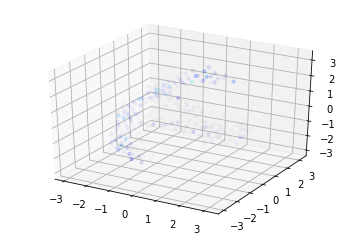

In [16]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
scatterSO3(to_np(grid_vertices), lik_est, ax=ax, clims = [0,.05], alims = [0,1], s=10)



In [51]:
#lik_distribution['bing_fixed'][1][1](grid_vertices.cuda())
obj_vals

{0: array([1.5572624e-16, 5.6068035e-09, 2.5850963e-21, ..., 4.9987486e-19,
        3.4300942e-22, 2.2192626e-21], dtype=float32),
 1: array([1.5828681e-18, 1.4727937e-08, 1.2670210e-21, ..., 8.2205526e-20,
        2.8433283e-23, 8.8089617e-23], dtype=float32),
 2: array([1.0266492e-17, 2.5055511e-09, 3.1272189e-21, ..., 4.9279440e-19,
        4.7533810e-22, 1.9978005e-21], dtype=float32),
 3: array([1.1644914e-16, 2.0249393e-08, 1.8605998e-20, ..., 1.8197138e-18,
        1.4417686e-21, 3.1166180e-21], dtype=float32),
 4: array([1.1377550e-15, 1.4526320e-07, 3.2834278e-20, ..., 6.8204288e-18,
        8.2043045e-21, 2.0253475e-20], dtype=float32),
 5: array([8.7869456e-16, 5.0087760e-07, 3.9088711e-20, ..., 1.6261403e-17,
        1.3383083e-20, 2.6720218e-20], dtype=float32),
 6: array([2.7274133e-16, 3.3381298e-08, 2.9946484e-20, ..., 1.5319600e-17,
        1.4496373e-20, 8.8606831e-20], dtype=float32),
 7: array([3.2518059e-15, 3.8025084e-07, 2.1284045e-19, ..., 5.1474179e-17,
       

In [54]:
from object_pose_utils.utils.interpolation import BinghamInterpolation, TetraInterpolation
from generic_pose.losses.bingham_loss import isoLikelihood, duelLikelihood, mLikelihood
import pathlib

for alg_key, alg_vals in lik_distribution.items():
    for obj, obj_vals in alg_vals.items():
        for j, lik_est in obj_vals.items():
            mat_filename = 'df_likelihoods/{}/{}_{}_lik.mat'.format(dataset.getPath(j), classes[obj], alg_key)
            pathlib.Path(mat_filename).parent.mkdir(parents=True, exist_ok=True)
            if(type(lik_est) in [BinghamInterpolation, isoLikelihood, duelLikelihood, mLikelihood]):
                lik_grid = to_np(lik_est(grid_vertices.cuda()))
                scio.savemat(mat_filename, {'lik_grid':lik_grid})
            else:
                if(type(lik_est) is torch.Tensor):
                    lik_est = to_np(lik_est.flatten())
                scio.savemat(mat_filename, {'lik_grid':lik_est})